# 양방향 LSTM을 이용한 품사 태깅(Part-of-speech Tagging using Bi-LSTM)

### 품사 태깅 데이터에 대한 이해와 전처리

In [1]:
import nltk
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [2]:
tagged_sentences = nltk.corpus.treebank.tagged_sents() # 토큰화에 품사 태깅이 된 데이터 받아오기
print("품사 태깅이 된 문장 개수: ", len(tagged_sentences)) # 문장 샘플의 개수 출력

품사 태깅이 된 문장 개수:  3914


In [3]:
print(tagged_sentences[0]) # 첫번째 샘플 출력

[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]


In [4]:
sentences, pos_tags = [], []
for tagged_sentence in tagged_sentences:
    sentence, tag_info = zip(*tagged_sentence)
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
    pos_tags.append(list(tag_info))

In [5]:
print(sentences[2])
print(pos_tags[2])

['Rudolph', 'Agnew', ',', '55', 'years', 'old', 'and', 'former', 'chairman', 'of', 'Consolidated', 'Gold', 'Fields', 'PLC', ',', 'was', 'named', '*-1', 'a', 'nonexecutive', 'director', 'of', 'this', 'British', 'industrial', 'conglomerate', '.']
['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', 'CC', 'JJ', 'NN', 'IN', 'NNP', 'NNP', 'NNP', 'NNP', ',', 'VBD', 'VBN', '-NONE-', 'DT', 'JJ', 'NN', 'IN', 'DT', 'JJ', 'JJ', 'NN', '.']


샘플의 최대 길이 : 271
샘플의 평균 길이 : 25.722024


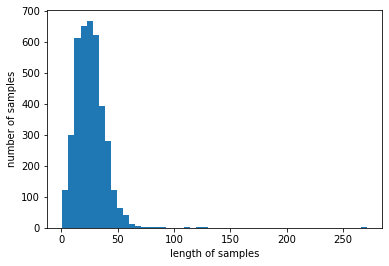

In [6]:
print('샘플의 최대 길이 : %d' %max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' %(sum(map(len, sentences)) / len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [7]:
def tokenize(samples):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(samples)
    return tokenizer

In [8]:
src_tokenizer = tokenize(sentences)
tar_tokenizer = tokenize(pos_tags)

In [9]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 11388
태깅 정보 집합의 크기 : 47


In [10]:
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(pos_tags)

In [11]:
print(X_train[:2])
print(y_train[:2])

[[5601, 3746, 1, 2024, 86, 331, 1, 46, 2405, 2, 131, 27, 6, 2025, 332, 459, 2026, 3], [31, 3746, 20, 177, 4, 5602, 2915, 1, 2, 2916, 637, 147, 3]]
[[3, 3, 8, 10, 6, 7, 8, 21, 13, 4, 1, 2, 4, 7, 1, 3, 10, 9], [3, 3, 17, 1, 2, 3, 3, 8, 4, 3, 19, 1, 9]]


In [12]:
max_len = 100
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2, random_state=777)

레이블에 해당하는 태깅 정보에 대해서 원-핫 인코딩을 수행합니다.

In [14]:
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

In [15]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (3131, 100)
훈련 샘플 레이블의 크기 : (3131, 100, 47)
테스트 샘플 문장의 크기 : (783, 100)
테스트 샘플 레이블의 크기 : (783, 100, 47)


### 양방향 LSTM(Bi-directional LSTM)으로 POS Tagger 만들기

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from tensorflow.keras.optimizers import Adam

In [17]:
model = Sequential()
model.add(Embedding(vocab_size, 128, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))
model.compile(loss='categorical_crossentropy',optimizer=Adam(0.001),metrics=['accuracy'])

In [18]:
model.fit(X_train, y_train, batch_size=128, epochs=6,  validation_data=(X_test, y_test))

Train on 3131 samples, validate on 783 samples
Epoch 1/6
3131/3131 [==============================] - 68s 22ms/sample - loss: 0.8541 - accuracy: 0.1522 - val_loss: 0.7561 - val_accuracy: 0.1631
Epoch 2/6
3131/3131 [==============================] - 73s 23ms/sample - loss: 0.7330 - accuracy: 0.2287 - val_loss: 0.6825 - val_accuracy: 0.3687
Epoch 3/6
3131/3131 [==============================] - 81s 26ms/sample - loss: 0.5991 - accuracy: 0.4403 - val_loss: 0.4722 - val_accuracy: 0.5278
Epoch 4/6
3131/3131 [==============================] - 80s 25ms/sample - loss: 0.3689 - accuracy: 0.6373 - val_loss: 0.2706 - val_accuracy: 0.7463
Epoch 5/6
3131/3131 [==============================] - 79s 25ms/sample - loss: 0.1959 - accuracy: 0.8333 - val_loss: 0.1492 - val_accuracy: 0.8662
Epoch 6/6
3131/3131 [==============================] - 79s 25ms/sample - loss: 0.1009 - accuracy: 0.9160 - val_loss: 0.0993 - val_accuracy: 0.9036


In [19]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

783/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


 테스트 정확도: 0.9036


In [21]:
index_to_word=src_tokenizer.index_word
index_to_tag=tar_tokenizer.index_word

i=5 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_tag[t].upper(), index_to_tag[pred].upper()))

단어             |실제값  |예측값
-----------------------------------
there            : EX      VBP
were             : VBD     VBD
concerns         : NNS     NNS
*ich*-1          : -NONE-  -NONE-
early            : RB      RB
in               : IN      IN
the              : DT      DT
day              : NN      NN
that             : IN      IN
wall             : NNP     NNP
street           : NNP     NNP
's               : POS     POS
sharp            : JJ      JJ
gains            : NNS     NNS
on               : IN      IN
tuesday          : NNP     NNP
were             : VBD     VBD
overdone         : VBN     NNP
and              : CC      CC
due              : JJ      JJ
for              : IN      IN
a                : DT      DT
reversal         : NN      NN
.                : .       .
